In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

In [8]:
#mg_noIBX_abs = pd.read_csv('/Users/turbold/Documents/CUSP/ADS/IBXRidership/mg_noIBX_abs.csv', index_col=0).fillna(0)
#mg_noIBX_norm = pd.read_csv('/Users/turbold/Documents/CUSP/ADS/IBXRidership/mg_noIBX_norm.csv', index_col=0).fillna(0)
mg_noIBX_log = pd.read_csv(r'../mg_noIBX_log_1.csv', index_col=0).drop(labels = ['industrial_pop_num', 'factryarea'], axis = 'columns')


#.replace([np.inf, -np.inf], np.nan).fillna(0)
mg_IBX_log = pd.read_csv(r'../mg_IBX_log_1.csv', index_col=0).drop(labels = ['industrial_pop_num', 'factryarea'], axis = 'columns')
#.replace([np.inf, -np.inf], np.nan).fillna(0)

In [20]:
mg_noIBX_log = mg_noIBX_log.replace([np.inf, -np.inf], np.nan).fillna(0)
mg_IBX_log = mg_IBX_log.replace([np.inf, -np.inf], np.nan).fillna(0)

In [9]:
cols_offpeak = ['cs_noibx_offpeak','lotarea', 'bldgarea',
                'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
                'strgearea', 'otherarea', 'numbldgs', 'numfloors',
                'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
                'housed_pop_Num', 'group_house_pop_num',
                'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
                'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
                'vacant_homes_num', 'Bus_Stops', 'Employment_est']

cols_peak = ['cs_noibx_peak','lotarea', 'bldgarea',
             'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
             'strgearea', 'otherarea', 'numbldgs', 'numfloors',
             'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
             'housed_pop_Num', 'group_house_pop_num',
             'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
             'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
             'vacant_homes_num', 'Bus_Stops', 'Employment_est']
             
#mg_noIBX_abs.columns

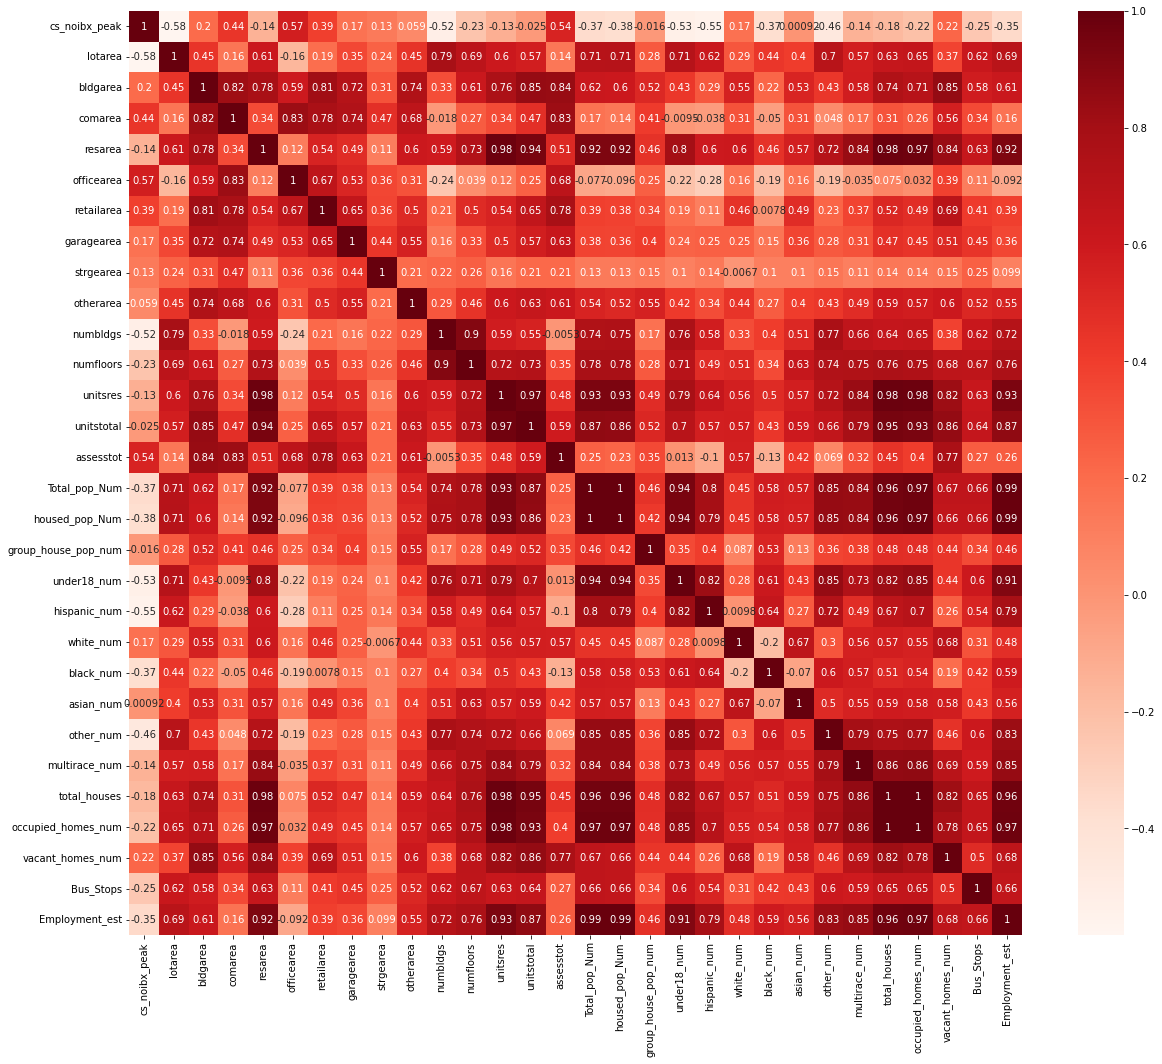

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(20,17))
cor = mg_noIBX_log[cols_peak].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig('/Users/turbold/Documents/CUSP/ADS/IBXRidership/Data Vis/IBX_cov_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

# Simple OLS on all columns

In [7]:
turnstile_data =['exits_weekday_evening',
       'entries_weekday_evening', 'exits_weekday_morning',
       'entries_weekday_morning', 'exits_weekday_overnight',
       'entries_weekday_overnight', 'exits_weekend_evening',
       'entries_weekend_evening', 'exits_weekend_morning',
       'entries_weekend_morning', 'exits_weekend_overnight',
       'entries_weekend_overnight']

peak_nonpeak = ['cs_noibx_peak', 'cs_noibx_offpeak']

# #Simple OLS on all variables
# for commute_period in turnstile_data:
#        if 'weekend' in commute_period:
#               model=sm.OLS(mg_noIBX_log[commute_period],mg_noIBX_log[cols_offpeak]).fit()  
#               print('{}:'.format(commute_period), model.rsquared)
#        elif 'overnight' in commute_period:
#               model=sm.OLS(mg_noIBX_log[commute_period],mg_noIBX_log[cols_offpeak]).fit()  
#               print('{}:'.format(commute_period),model.rsquared)
#        else:
#               model=sm.OLS(mg_noIBX_log[commute_period],mg_noIBX_log[cols_peak]).fit() 
#               print('{}:'.format(commute_period), model.rsquared)

# LassoCV for absolute values

In [ ]:
#LassoCV scores on absolute values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_abs[cols_peak], mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_abs[cols_peak], mg_noIBX_abs[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_peak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))


exits_weekday_evening: 0.15589336728564995
exits_weekday_evening Selected Features: ['assesstot' 'vacant_homes_num' 'occupied_homes_num' 'total_houses'
 'multirace_num']
entries_weekday_evening: 0.37667712953521937
entries_weekday_evening Selected Features: ['lotarea' 'assesstot' 'vacant_homes_num' 'occupied_homes_num'
 'total_houses']
exits_weekday_morning: 0.3914032209236177
exits_weekday_morning Selected Features: ['lotarea' 'assesstot' 'vacant_homes_num' 'occupied_homes_num'
 'total_houses']
entries_weekday_morning: 0.1435951240460398
entries_weekday_morning Selected Features: ['assesstot' 'vacant_homes_num' 'occupied_homes_num' 'total_houses'
 'multirace_num']
exits_weekday_overnight: 0.1824501168279924
exits_weekday_overnight Selected Features: ['lotarea' 'bldgarea' 'assesstot' 'vacant_homes_num' 'occupied_homes_num']
entries_weekday_overnight: 0.1518831778871088
entries_weekday_overnight Selected Features: ['assesstot' 'vacant_homes_num' 'occupied_homes_num' 'total_houses'
 'mul

# LassoCV on log values

In [6]:
lassocv_log_rsquare = {}


#LassoCV scores on log values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
           r_square = Lasso_model.score(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), r_square)
           lassocv_log_rsquare[commute_period]= r_square
           #print top features in order of importance
           importance = np.abs(Lasso_model.coef_)
           pos_index = len(importance[importance != 0])
           idx_third = importance.argsort()[-pos_index]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()
           name_features = list(np.array(cols_offpeak)[idx_features])
           feature_coef =-np.sort(-importance)
           feature_coef = list(feature_coef[feature_coef != 0])
           #offpeak=pd.DataFrame(list(zip(name_features, feature_coef)),columns= ['features','coef'])
           print('{} Selected Features: {}'.format(commute_period, [name_features, feature_coef]))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
           r_square = Lasso_model.score(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), r_square)
           lassocv_log_rsquare[commute_period]= r_square
           #print top features in order of importance
           importance = np.abs(Lasso_model.coef_)
           pos_index = len(importance[importance != 0])
           idx_third = importance.argsort()[-pos_index]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()
           name_features = list(np.array(cols_offpeak)[idx_features])
           feature_coef =-np.sort(-importance)
           feature_coef = list(feature_coef[feature_coef != 0])
           print('{} Selected Features: {}'.format(commute_period, [name_features, feature_coef]))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period])
           r_square = Lasso_model.score(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), r_square)
           lassocv_log_rsquare[commute_period]= r_square
           #print top features in order of importance
           importance = np.abs(Lasso_model.coef_)
           pos_index = len(importance[importance != 0])
           idx_third = importance.argsort()[-pos_index]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()
           name_features = list(np.array(cols_peak)[idx_features])
           feature_coef =-np.sort(-importance)
           feature_coef = list(feature_coef[feature_coef != 0])
           #peak=pd.DataFrame(list(zip(name_features, feature_coef)),columns= ['features','coef'])
           print('{} Selected Features: {}'.format(commute_period, [name_features, feature_coef]))

exits_weekday_evening: 0.5166277999594238
exits_weekday_evening Selected Features: [['resarea', 'occupied_homes_num', 'numfloors', 'lotarea', 'unitstotal', 'numbldgs', 'Bus_Stops', 'assesstot', 'retailarea', 'other_num', 'Employment_est', 'asian_num', 'hispanic_num', 'white_num', 'multirace_num', 'comarea', 'vacant_homes_num', 'under18_num', 'garagearea', 'otherarea', 'strgearea', 'black_num', 'officearea', 'group_house_pop_num', 'housed_pop_Num', 'Total_pop_Num', 'total_houses', 'bldgarea', 'unitsres', 'cs_noibx_peak'], [0.7088073416894566, 0.62906440028688, 0.43715236529791207, 0.3465653256321855, 0.3338946717781756, 0.32581635580420976, 0.23213732937787457, 0.21574724418353544, 0.20583441551726916, 0.18137756311845757, 0.17696657610360733, 0.1633903839835966, 0.1583937066895376, 0.15694396097974092, 0.14363337426728584, 0.09956739060675888, 0.07764329312972945, 0.05953539820044077, 0.0500958319414639, 0.028132694788637627, 0.012330492805814743, 0.006065118596322758, 0.00419293779548

In [ ]:
Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_peak], mg_noIBX_log['entries_weekday_evening'])
r_square = Lasso_model.score(mg_noIBX_log[cols_offpeak], mg_noIBX_log['entries_weekday_evening'])
 #print r-square for commute period
print('{}:'.format('entries_weekday_evening'), r_square)
lassocv_log_rsquare[commute_period]= r_square
#print top features in order of importance
importance = np.abs(Lasso_model.coef_)
idx_third = importance.argsort()[-10]
threshold = importance[idx_third] + 0.01
idx_features = (-importance).argsort()[:10]
name_features = np.array(cols_offpeak)[idx_features]
print('{} Selected Features: {}'.format(commute_period, name_features), )
idx_features

entries_weekday_evening: 0.725681559211454
entries_weekend_overnight Selected Features: ['lotarea' 'assesstot' 'Bus_Stops' 'retailarea' 'numbldgs' 'other_num'
 'asian_num' 'garagearea' 'unitstotal' 'white_num']


array([ 1, 14, 28,  6, 10, 23, 22,  7, 13, 20])

# LassoCV on normalized values

In [ ]:
#LassoCV scores on norm values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period]))
           #print top features in order of importance
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period]))
           
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_norm[cols_peak], mg_noIBX_norm[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_norm[cols_peak], mg_noIBX_norm[commute_period]))
           #print top features in order of importance
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_peak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))

# Grid Search on PCA and Lasso

In [ ]:
# make a pipeline - specify the model
pipe = Pipeline([("scale", preprocessing.StandardScaler()),
                 ("reduce_dims", PCA()),
                 ("lasso", Lasso())
                ])

param_grid = dict(reduce_dims__n_components = np.arange(1,31,1),
                  lasso__alpha = 2.0**(np.arange(-10, 10, 1)))

grid = GridSearchCV(pipe, param_grid=param_grid, verbose=True,n_jobs=-1, cv=5)



#Loop through different independent variables                  
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              grid.fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       elif 'overnight' in commute_period:
              grid.fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       else:
              grid.fit(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)

In [ ]:
grid.best_params_
mg_noIBX_abs.shape

(424, 58)

# Creating Index columns for Housing and Demographics using PCA to reduce mulitcolinearity

In [15]:
pd.set_option('display.max_columns', 999)

In [16]:
mg_IBX_log[cols_peak]

,cs_noibx_peak,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,otherarea,numbldgs,numfloors,unitsres,unitstotal,assesstot,Total_pop_Num,housed_pop_Num,group_house_pop_num,under18_num,hispanic_num,white_num,black_num,asian_num,other_num,multirace_num,total_houses,occupied_homes_num,vacant_homes_num,Bus_Stops,Employment_est
0,0.022649,14.800337,14.428242,13.576895,13.745622,12.742419,11.605464,11.040599,9.003309,12.489699,3.065612,5.144867,6.826222,6.921007,20.037300,7.189131,7.089372,4.834664,4.785914,5.024356,6.690062,4.136770,5.485091,2.547917,3.952307,6.769659,6.577074,5.027693,2.397895,7.024843
1,0.025604,12.130081,14.624265,14.377155,12.156223,14.170175,12.062017,11.040255,9.507777,11.118893,3.134126,5.396867,5.673069,6.458697,19.598824,5.997473,5.897827,3.641931,3.280642,4.244751,5.225964,3.850395,4.402292,1.413687,2.629808,5.606418,5.460713,3.608279,2.890372,5.786083
2,0.024396,12.092861,13.844648,12.961091,13.267247,12.405357,11.528345,9.458080,8.085312,11.063050,3.833007,5.395577,6.395520,6.547598,18.855470,6.778691,6.739125,3.529178,4.424306,4.158480,6.520853,3.005719,4.247685,2.133327,3.616262,6.355859,6.223137,4.270730,2.484907,6.614408
3,0.020454,12.249340,14.252788,14.179121,11.280086,14.082996,10.632056,9.606406,8.424494,11.170152,1.930308,4.456606,4.286471,5.180447,18.742771,4.913529,4.826528,2.428501,3.047801,2.712439,4.350313,2.321817,3.182273,0.770273,1.959273,4.329258,4.111366,2.698535,3.332205,4.696568
4,0.021334,12.850410,14.257545,13.675609,13.375275,13.197601,11.274940,10.988997,8.559928,12.134260,4.234678,5.660095,6.449035,7.792843,18.868180,6.998801,6.953781,3.875739,5.159184,4.578054,6.621957,3.798712,4.829044,2.175708,4.220048,6.364202,6.277986,3.870514,3.555348,6.719064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,0.000000,14.939400,14.538850,12.786176,14.246686,10.122611,11.439705,9.432155,10.945905,11.820096,6.959455,7.494006,7.408599,7.456357,18.315669,8.495617,8.479170,4.379757,6.849595,7.046556,7.340893,4.379668,7.613954,3.346145,4.216725,7.464816,7.399923,4.697539,3.555348,8.278172
429,0.000000,13.961032,13.861304,12.851904,13.293891,9.532967,10.228361,11.925386,10.705043,11.397341,5.798971,6.377251,6.469731,6.532129,17.583511,7.512041,7.490012,3.685636,5.938138,6.361863,5.791761,3.760552,6.732732,2.635226,3.283726,6.399588,6.335691,3.617335,3.583519,7.176065
430,0.000000,17.411853,15.891221,14.938131,15.242030,12.594562,13.604868,13.188657,12.099857,13.917151,8.066251,8.453274,8.287803,8.366637,20.451108,9.388291,9.379981,4.593860,7.755603,6.828899,8.017651,8.804369,6.421800,4.882944,6.361354,8.386855,8.324654,5.578533,1.945910,9.160163
431,0.000000,15.257446,14.912292,13.459797,14.531868,11.420151,11.606922,11.009642,11.409015,12.592538,7.033289,7.670817,7.619518,7.678775,18.418131,8.793211,8.789669,3.148503,7.152973,5.940430,6.517414,8.516003,4.798447,4.208249,5.857419,7.766414,7.717666,4.721053,2.397895,8.478276


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

cols_housing = ['unitsres','unitstotal','total_houses', 'occupied_homes_num',
       'vacant_homes_num','resarea']

cols_dems = ['Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num']

#composite score for housing 
X_log_scale_hs = StandardScaler().fit_transform(mg_noIBX_log[cols_housing])
pca_hs = PCA(n_components=1)
housing_composite = pca_hs.fit_transform(X_log_scale_hs)
mg_noIBX_log['housing_ind'] = housing_composite

X_log_scale_hs = StandardScaler().fit_transform(mg_IBX_log[cols_housing])
pca_hs = PCA(n_components=1)
housing_composite = pca_hs.fit_transform(X_log_scale_hs)
mg_IBX_log['housing_ind'] = housing_composite

#and demographics 
X_log_scale_dem = StandardScaler().fit_transform(mg_noIBX_log[cols_dems])
pca_dem = PCA(n_components=1)
demo_composite = pca_dem.fit_transform(X_log_scale_dem)
mg_noIBX_log['dem_ind'] = demo_composite

X_log_scale_dem = StandardScaler().fit_transform(mg_IBX_log[cols_dems])
pca_dem = PCA(n_components=1)
demo_composite = pca_dem.fit_transform(X_log_scale_dem)
mg_IBX_log['dem_ind'] = demo_composite

offpeak_ind = ['cs_noibx_offpeak','lotarea', 'bldgarea',
                'comarea', 'officearea', 'retailarea', 'garagearea',
                'strgearea', 'otherarea', 'numbldgs', 'numfloors',
                 'assesstot', 'housing_ind', 'dem_ind',
                'Bus_Stops', 'Employment_est']

peak_ind = ['cs_noibx_peak','lotarea', 'bldgarea',
                'comarea', 'officearea', 'retailarea', 'garagearea',
                'strgearea', 'otherarea', 'numbldgs', 'numfloors',
                 'assesstot', 'housing_ind', 'dem_ind',
                'Bus_Stops', 'Employment_est']

# LassoCV on log values and inexed housing and demographic features

In [ ]:
#LassoCV scores on log values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[offpeak_ind], mg_noIBX_log[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_log[offpeak_ind], mg_noIBX_log[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(offpeak_ind)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[offpeak_ind], mg_noIBX_log[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_log[offpeak_ind], mg_noIBX_log[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(offpeak_ind)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[peak_ind], mg_noIBX_log[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_log[peak_ind], mg_noIBX_log[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(peak_ind)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))

exits_weekday_evening: 0.4497154603919963
exits_weekday_evening Selected Features: ['numfloors' 'numbldgs' 'lotarea' 'bldgarea' 'retailarea']
entries_weekday_evening: 0.7081048781203789
entries_weekday_evening Selected Features: ['lotarea' 'assesstot' 'Bus_Stops' 'retailarea' 'numbldgs']
exits_weekday_morning: 0.6121371658711185
exits_weekday_morning Selected Features: ['lotarea' 'assesstot' 'Bus_Stops' 'retailarea' 'numbldgs']
entries_weekday_morning: 0.46303680472826325
entries_weekday_morning Selected Features: ['retailarea' 'lotarea' 'Bus_Stops' 'numbldgs' 'dem_ind']
exits_weekday_overnight: 0.36530582528419175
exits_weekday_overnight Selected Features: ['numfloors' 'numbldgs' 'Bus_Stops' 'lotarea' 'retailarea']
entries_weekday_overnight: 0.47059022002702644
entries_weekday_overnight Selected Features: ['numfloors' 'numbldgs' 'retailarea' 'Bus_Stops' 'dem_ind']
exits_weekend_evening: 0.5187539095498495
exits_weekend_evening Selected Features: ['bldgarea' 'numbldgs' 'numfloors' 'lot

# Gridsearch Tuning

In [ ]:
# make a pipeline - specify the model
pipe = Pipeline([("scale", preprocessing.StandardScaler()),
                 ("reduce_dims", PCA()),
                 ("lasso", Lasso())
                ])

param_grid = dict(reduce_dims__n_components = np.arange(1,31,1),
                  lasso__alpha = 2.0**(np.arange(-10, 10, 1)))

grid = GridSearchCV(pipe, param_grid=param_grid, verbose=True,n_jobs=-1, cv=5)



#Loop through different independent variables                  
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              grid.fit(current[cols_offpeak], current[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       elif 'overnight' in commute_period:
              grid.fit(current[cols_offpeak], current[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       else:
              grid.fit(current[cols_peak], current[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
exits_weekday_evening best R-score: 0.2661323938716164
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=8)),
                ('lasso', Lasso(alpha=0.0009765625))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
entries_weekday_evening best R-score: 0.6271166023376946
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=8)),
                ('lasso', Lasso(alpha=0.001953125))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
exits_weekday_morning best R-score: 0.4790387998220279
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=8)),
                ('lasso', Lasso(alpha=0.0009765625))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
entries_weekday_morning best R-score: 0.20134784913122017
Pipeline(steps=[('scale', StandardScaler()),
             

In [ ]:
# make a pipeline - specify the model
pipe = Pipeline([("scale", preprocessing.StandardScaler()),
                 ("lasso", Lasso(max_iter=100000))
                ])

param_grid = dict(lasso__alpha = [.25])

grid = GridSearchCV(pipe, param_grid=param_grid, verbose=True, n_jobs=-1, cv=5)



#Loop through different independent variables                  
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              grid.fit(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       elif 'overnight' in commute_period:
              grid.fit(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       else:
              grid.fit(mg_noIBX_abs[cols_peak], mg_noIBX_abs[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)

In [ ]:
# make a pipeline - specify the model
pipe = Pipeline([ ("lasso", Lasso(max_iter=10000))
                ])

param_grid = dict(lasso__alpha = 2.0**(np.arange(-10, 10, 1)))

grid = GridSearchCV(pipe, param_grid=param_grid, verbose=True,n_jobs=-1, cv=5)

grid.fit(current[cols_offpeak], current[commute_period])
#print('{} best R-score:'.format(commute_period), grid.best_score_)
print(grid.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Pipeline(steps=[('lasso', Lasso(alpha=0.0009765625, max_iter=10000))])


In [ ]:
Lasso_model = LassoCV(cv=5, random_state=2012, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_peak], mg_noIBX_log['entries_weekday_evening'])
r_square = Lasso_model.score(mg_noIBX_log[cols_peak], mg_noIBX_log['entries_weekday_evening'])
#print r-square for commute period
print('entries_weekday_evening', r_square)
lassocv_log_rsquare['entries_weekday_evening']= r_square
#print top features in order of importance
importance = np.abs(Lasso_model.coef_)
pos_index = len(importance[importance != 0])
idx_third = importance.argsort()[-pos_index]
threshold = importance[idx_third] + 0.01
idx_features = (-importance).argsort()
name_features = list(np.array(cols_peak)[idx_features])
feature_coef =-np.sort(-importance)
feature_coef = list(feature_coef[feature_coef != 0])
peak=pd.DataFrame(list(zip(name_features, feature_coef)),columns= ['Features','Coefficient'])
print('{} Selected Features: {}'.format(commute_period, [name_features, feature_coef]))

entries_weekday_evening 0.725681559211454
entries_weekend_overnight Selected Features: [['lotarea', 'assesstot', 'Bus_Stops', 'retailarea', 'numbldgs', 'other_num', 'asian_num', 'garagearea', 'unitstotal', 'white_num', 'otherarea', 'hispanic_num', 'vacant_homes_num', 'strgearea', 'officearea', 'group_house_pop_num', 'multirace_num', 'total_houses', 'occupied_homes_num', 'black_num', 'cs_noibx_peak', 'housed_pop_Num', 'Total_pop_Num', 'unitsres', 'numfloors', 'resarea', 'comarea', 'bldgarea', 'under18_num', 'Employment_est'], [0.43487440960352647, 0.4128972891284179, 0.2565857788465682, 0.19483609306455252, 0.16198894409328066, 0.1452550542942254, 0.12309115617725148, 0.08381994847958135, 0.07392921796855288, 0.050661925800983464, 0.04883800845947492, 0.03122604920697195, 0.029044775519910644, 0.02309125244079561, 0.021804048701109555, 0.018736897635379814]]


In [ ]:
import altair as alt
import selenium

alt.Chart(peak).mark_bar().encode(
    y=alt.Y('Features:N', sort='-x'),
    x='Coefficient'
).properties(
    title='Important Features of Lasso CV Weekday Evening Entries'
)#.save('/Users/turbold/Documents/CUSP/ADS/IBXRidership/Data Vis/peak_chart.png', scale_factor=2.0)


alt.Chart(...)

In [ ]:
Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log['entries_weekend_evening'])
#print top features in order of importance
importance = np.abs(Lasso_model.coef_)
pos_index = len(importance[importance != 0])
idx_third = importance.argsort()[-pos_index]
threshold = importance[idx_third] + 0.01
idx_features = (-importance).argsort()
name_features = list(np.array(cols_offpeak)[idx_features])
feature_coef =-np.sort(-importance)
feature_coef = list(feature_coef[feature_coef != 0])
offpeak=pd.DataFrame(list(zip(name_features, feature_coef)),columns= ['Features','Coefficients'])

In [ ]:
import altair as alt

alt.Chart(offpeak).mark_bar().encode(
    y=alt.Y('Features:N', sort='-x'),
    x='Coefficients'
).properties(
    title='Important Features of Lasso CV Weekend Evening Entries'
)

alt.Chart(...)

In [23]:
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score
from time import time

In [11]:
#Ridge on all variables
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period]) 
              print('{}:'.format(commute_period), model.score(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period]))
       elif 'overnight' in commute_period:
              model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period]) 
              print('{}:'.format(commute_period), model.score(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period]))
       else:
              model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period]) 
              print('{}:'.format(commute_period), model.score(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period]))

exits_weekday_evening: 0.551006069211575
entries_weekday_evening: 0.7607439710982088
exits_weekday_morning: 0.6728510509712076
entries_weekday_morning: 0.6033257858281245
exits_weekday_overnight: 0.45141167123011783
entries_weekday_overnight: 0.5225372482606235
exits_weekend_evening: 0.5886845210408828
entries_weekend_evening: 0.6861099422580932
exits_weekend_morning: 0.6201042169047379
entries_weekend_morning: 0.5894127282005759
exits_weekend_overnight: 0.4718277105848381
entries_weekend_overnight: 0.6335803568217548


# Best Model is Here: RidgeCV with index for demo and housing

In [57]:
#Ridge on index'd demographic and population
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[offpeak_ind], mg_noIBX_log[commute_period]) 
              print('{} avg. in sample R-square:'.format(commute_period), model.score(mg_noIBX_log[offpeak_ind], mg_noIBX_log[commute_period]))
              globals()['{}'.format(commute_period)] = np.exp(model.predict(mg_IBX_log[offpeak_ind]))
              globals()['{}_is'.format(commute_period)] = np.exp(model.predict(mg_noIBX_log[offpeak_ind]))
              print('avg. out-of sample R-square:', np.mean((cross_val_score(model, mg_noIBX_log[offpeak_ind], mg_noIBX_log[commute_period], cv=5))))
       elif 'overnight' in commute_period:
              model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[offpeak_ind], mg_noIBX_log[commute_period]) 
              print('{} avg. in sample R-square:'.format(commute_period), model.score(mg_noIBX_log[offpeak_ind], mg_noIBX_log[commute_period]))
              globals()['{}'.format(commute_period)] = np.exp(model.predict(mg_IBX_log[offpeak_ind]))
              globals()['{}_is'.format(commute_period)] = np.exp(model.predict(mg_noIBX_log[offpeak_ind]))
              print('avg. out-of sample R-square:', np.mean(cross_val_score(model, mg_noIBX_log[offpeak_ind], mg_noIBX_log[commute_period], cv=5)))
       else:
              model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[peak_ind], mg_noIBX_log[commute_period]) 
              print('{} avg. in sample R-square:'.format(commute_period), model.score(mg_noIBX_log[peak_ind], mg_noIBX_log[commute_period]))
              globals()['{}'.format(commute_period)] = np.exp(model.predict(mg_IBX_log[peak_ind]))
              globals()['{}_is'.format(commute_period)] = np.exp(model.predict(mg_noIBX_log[peak_ind]))
              print('avg. out-of sample R-square:', np.mean(cross_val_score(model, mg_noIBX_log[peak_ind], mg_noIBX_log[commute_period], cv=5)))

exits_weekday_evening avg. in sample R-square: 0.48483773286554255
avg. out-of sample R-square: 0.25283087578718294
entries_weekday_evening avg. in sample R-square: 0.7367518978820242
avg. out-of sample R-square: 0.5938261845951021
exits_weekday_morning avg. in sample R-square: 0.6441090891378437
avg. out-of sample R-square: 0.4861549091347184
entries_weekday_morning avg. in sample R-square: 0.5000007501733563
avg. out-of sample R-square: 0.2211325609113813
exits_weekday_overnight avg. in sample R-square: 0.38648790216084583
avg. out-of sample R-square: 0.1147597967294552
entries_weekday_overnight avg. in sample R-square: 0.4822565008580768
avg. out-of sample R-square: 0.2237819394550785
exits_weekend_evening avg. in sample R-square: 0.544170272533566
avg. out-of sample R-square: 0.3180269554457986
entries_weekend_evening avg. in sample R-square: 0.6728898392631891
avg. out-of sample R-square: 0.47524661193836176
exits_weekend_morning avg. in sample R-square: 0.6019309365149467
avg. ou

In [37]:
#Nested cross-validation R2

from sklearn.model_selection import train_test_split

period_scores = {}

for commute_period in turnstile_data:

  scores = []

  if ('weekend' in commute_period) or ('overnight' in commute_period):

    for i in range(100): #do 100 train-test splits and find the r2 score for each split

      X_train, X_test, y_train, y_test = train_test_split(mg_noIBX_log[offpeak_ind], mg_noIBX_log[commute_period], test_size = 0.2)

      model_cv = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(X_train, y_train) 

      cv_pred = model_cv.predict(X_test)

      scores.append(r2_score(y_test, cv_pred))


  else:

    for i in range(100):

      X_train, X_test, y_train, y_test = train_test_split(mg_noIBX_log[peak_ind], mg_noIBX_log[commute_period], test_size = 0.2)

      model_cv = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(X_train, y_train) 

      cv_pred = model_cv.predict(X_test)

      scores.append(r2_score(y_test, cv_pred))

  period_scores[commute_period] = np.mean(scores) #take the mean for each set of 100 scores for each output/time period


In [39]:
period_scores

{'entries_weekday_evening': 0.6950103972976589,
 'entries_weekday_morning': 0.42423187054958034,
 'entries_weekday_overnight': 0.4123334008716888,
 'entries_weekend_evening': 0.6181710851430194,
 'entries_weekend_morning': 0.4325201933949389,
 'entries_weekend_overnight': 0.5330959793741598,
 'exits_weekday_evening': 0.41612968862491806,
 'exits_weekday_morning': 0.5890290686242687,
 'exits_weekday_overnight': 0.31600129979450875,
 'exits_weekend_evening': 0.4715022038566525,
 'exits_weekend_morning': 0.5438420857839203,
 'exits_weekend_overnight': 0.3223603726474522}

In [26]:
for commute_period in turnstile_data:
    if 'weekend_evening' in commute_period:
        we_evening = pd.DataFrame({'Complex ID':mg_IBX_log['Complex ID'], 'VoroID': mg_IBX_log['VoroID'], 'entries':entries_weekend_evening,'exits': exits_weekend_evening})
        we_evening_is = pd.DataFrame({'Complex ID':mg_noIBX_log['Complex ID'], 'VoroID': mg_noIBX_log['VoroID'], 'entries':entries_weekend_evening_is,'exits': exits_weekend_evening_is})
        we_evening.to_csv('Outputs/we_evening_pred.csv')
        we_evening_is.to_csv('Outputs/we_evening_pred_is.csv')
    elif 'weekend_morning' in commute_period:
        we_morning = pd.DataFrame({'Complex ID':mg_IBX_log['Complex ID'], 'VoroID': mg_IBX_log['VoroID'], 'entries':entries_weekend_morning,'exits': exits_weekend_morning})
        we_morning_is = pd.DataFrame({'Complex ID':mg_noIBX_log['Complex ID'], 'VoroID': mg_noIBX_log['VoroID'], 'entries':entries_weekend_morning_is,'exits': exits_weekend_morning_is})
        we_morning.to_csv('Outputs/we_morning_pred.csv')
        we_morning_is.to_csv('Outputs/we_morning_pred_is.csv')
    elif 'weekend_overnight' in commute_period:
        we_overnight = pd.DataFrame({'Complex ID':mg_IBX_log['Complex ID'], 'VoroID': mg_IBX_log['VoroID'], 'entries':entries_weekend_overnight,'exits': exits_weekend_overnight})
        we_overnight_is = pd.DataFrame({'Complex ID':mg_noIBX_log['Complex ID'], 'VoroID': mg_noIBX_log['VoroID'], 'entries':entries_weekend_overnight_is,'exits': exits_weekend_overnight_is})
        we_overnight.to_csv('Outputs/we_overnight_pred.csv')
        we_overnight_is.to_csv('Outputs/we_overnight_pred_is.csv')
    elif 'weekday_morning' in commute_period:
        wd_morning = pd.DataFrame({'Complex ID':mg_IBX_log['Complex ID'], 'VoroID': mg_IBX_log['VoroID'], 'entries':entries_weekday_morning,'exits': exits_weekday_morning})
        wd_morning_is = pd.DataFrame({'Complex ID':mg_noIBX_log['Complex ID'], 'VoroID': mg_noIBX_log['VoroID'], 'entries':entries_weekday_morning_is,'exits': exits_weekday_morning_is})
        wd_morning.to_csv('Outputs/wd_morning_pred.csv')
        wd_morning_is.to_csv('Outputs/wd_morning_pred_is.csv')
    elif 'weekday_evening' in commute_period:
        wd_evening = pd.DataFrame({'Complex ID':mg_IBX_log['Complex ID'], 'VoroID': mg_IBX_log['VoroID'], 'entries':entries_weekday_evening,'exits': exits_weekday_evening})
        wd_evening_is = pd.DataFrame({'Complex ID':mg_noIBX_log['Complex ID'], 'VoroID': mg_noIBX_log['VoroID'], 'entries':entries_weekday_evening_is,'exits': exits_weekday_evening_is})
        wd_evening.to_csv('Outputs/wd_evening_pred.csv')
        wd_evening_is.to_csv('Outputs/wd_evening_pred_is.csv')
    elif 'weekday_overnight' in commute_period:
        wd_overnight = pd.DataFrame({'Complex ID':mg_IBX_log['Complex ID'], 'VoroID': mg_IBX_log['VoroID'], 'entries':entries_weekday_overnight,'exits': exits_weekday_overnight})
        wd_overnight_is = pd.DataFrame({'Complex ID':mg_noIBX_log['Complex ID'], 'VoroID': mg_noIBX_log['VoroID'], 'entries':entries_weekday_overnight_is,'exits': exits_weekday_overnight_is})
        wd_overnight.to_csv('Outputs/wd_overnight_pred.csv')
        wd_overnight_is.to_csv('Outputs/wd_overnight_pred_is.csv')


In [ ]:
selected_features = ['cs_noibx_peak', 'retailarea', 'garagearea', 'numbldgs', 'numfloors',
 'white_num', 'asian_num', 'other_num', 'Bus_Stops', 'Employment_est']

In [ ]:
model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[peak_ind], mg_noIBX_log['entries_weekday_evening']) 

print('{}:'.format(commute_period), model.score(mg_noIBX_log[peak_ind], mg_noIBX_log['entries_weekday_evening']))

entries_weekend_overnight: 0.7367518978819667


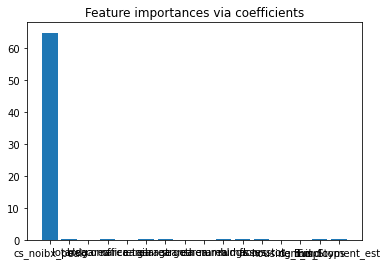

In [ ]:
importance = np.abs(model.coef_)
feature_names = np.array(peak_ind)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [ ]:
importance = np.abs(model.coef_)
pos_index = len(importance[importance != 0])
idx_third = importance.argsort()[-pos_index]
threshold = importance[idx_third] + 0.01
idx_features = (-importance).argsort()
name_features = list(np.array(peak_ind)[idx_features])
feature_coef =-np.sort(-importance)
feature_coef = list(feature_coef[feature_coef != 0])
peak=pd.DataFrame(list(zip(name_features, feature_coef)),columns= ['Features','Coefficients'])

In [ ]:
peak

,Features,Coefficients
0,cs_noibx_peak,64.896731
1,numbldgs,0.420228
2,numfloors,0.364681
3,lotarea,0.260676
4,Bus_Stops,0.259198
5,retailarea,0.257315
6,assesstot,0.199008
7,comarea,0.176104
8,Employment_est,0.166808
9,garagearea,0.147916


<AxesSubplot:>

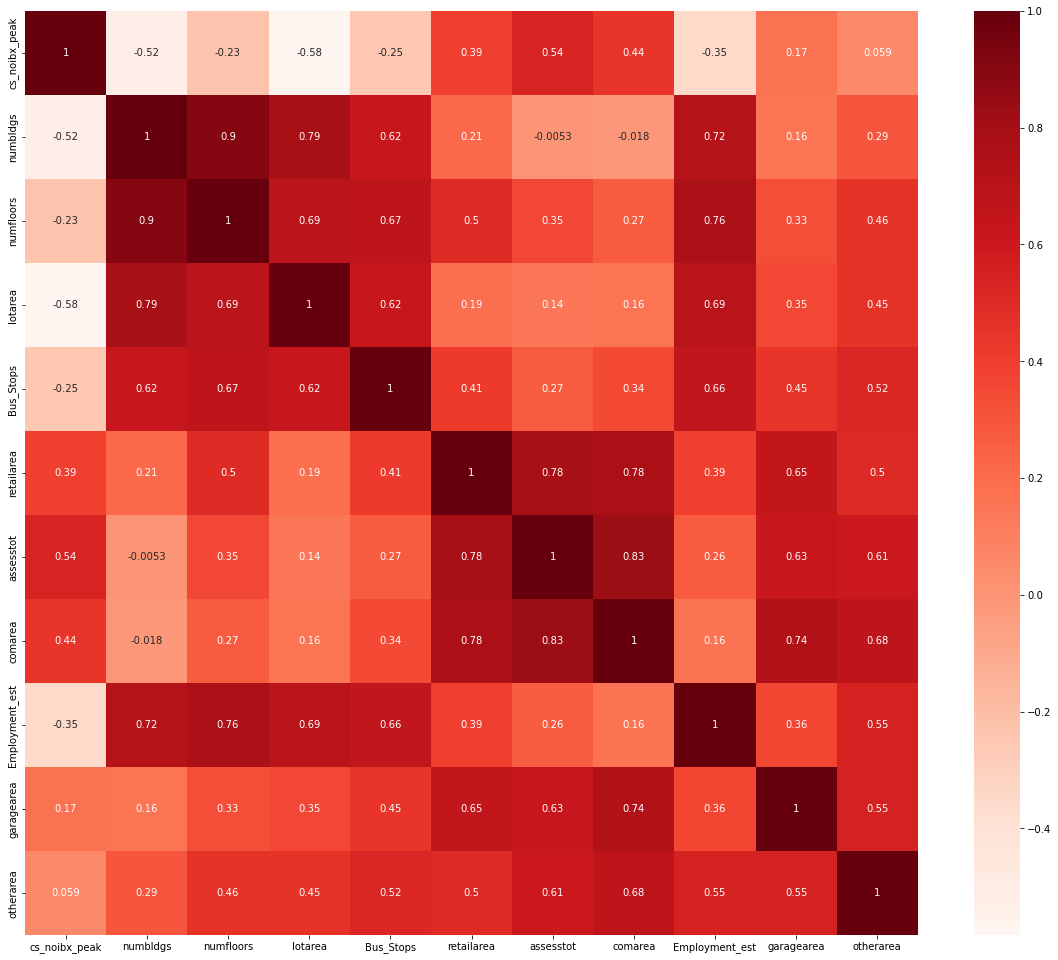

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(20,17))
cor = mg_noIBX_log[peak['Features']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)


In [ ]:
import altair as alt

alt.Chart(peak).mark_bar().encode(
    y=alt.Y('Features:N', sort='-x'),
    x='Coefficients'
).properties(
    title='Important Features of Ridge Weekday Evening Entries'
)

alt.Chart(...)

In [ ]:
tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    model, n_features_to_select=10, direction="backward"
).fit(mg_noIBX_log[cols_peak], mg_noIBX_log['entries_weekday_evening'])
toc_bwd = time()

print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features selected by backward sequential selection: ['cs_noibx_peak' 'retailarea' 'garagearea' 'numbldgs' 'numfloors'
 'white_num' 'asian_num' 'other_num' 'Bus_Stops' 'Employment_est']
Done in 233.269s


In [ ]:
# define standard scaler
scaler = StandardScaler()
# transform data
mg_noIBX_abs_scaled = pd.DataFrame(scaler.fit_transform(mg_noIBX_abs[cols_peak]), columns=cols_peak)

In [ ]:
#LassoCV scores on scaled abs values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_abs_scaled, mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_abs_scaled, mg_noIBX_abs[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_abs_scaled, mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_abs_scaled, mg_noIBX_abs[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_abs_scaled, mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_abs_scaled, mg_noIBX_abs[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_peak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))

exits_weekday_evening: 0.4224096400171733
exits_weekday_evening Selected Features: ['retailarea' 'cs_noibx_peak' 'numbldgs' 'officearea' 'strgearea']
entries_weekday_evening: 0.6049195925282086
entries_weekday_evening Selected Features: ['retailarea' 'cs_noibx_peak' 'officearea' 'multirace_num' 'strgearea']
exits_weekday_morning: 0.6166789684492209
exits_weekday_morning Selected Features: ['retailarea' 'officearea' 'cs_noibx_peak' 'strgearea' 'numfloors']
entries_weekday_morning: 0.40133266129549616
entries_weekday_morning Selected Features: ['retailarea' 'hispanic_num' 'cs_noibx_peak' 'officearea' 'strgearea']
exits_weekday_overnight: 0.3445186807843188
exits_weekday_overnight Selected Features: ['retailarea' 'cs_noibx_offpeak' 'numbldgs' 'hispanic_num' 'officearea']
entries_weekday_overnight: 0.29893883967214574
entries_weekday_overnight Selected Features: ['retailarea' 'officearea' 'cs_noibx_offpeak' 'assesstot'
 'group_house_pop_num']
exits_weekend_evening: 0.4491133181832042
exits

In [ ]:
#RidgeCV scores on scaled abs values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Ridge_model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_abs_scaled, mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Ridge_model.score(mg_noIBX_abs_scaled, mg_noIBX_abs[commute_period]))
           importance = np.abs(Ridge_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       elif 'overnight' in commute_period:
           Ridge_model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_abs_scaled, mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Ridge_model.score(mg_noIBX_abs_scaled, mg_noIBX_abs[commute_period]))
           importance = np.abs(Ridge_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       else:
           Ridge_model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_abs_scaled, mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Ridge_model.score(mg_noIBX_abs_scaled, mg_noIBX_abs[commute_period]))
           importance = np.abs(Ridge_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_peak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))

exits_weekday_evening: 0.3442465825614086
exits_weekday_evening Selected Features: ['cs_noibx_peak' 'retailarea' 'officearea' 'comarea' 'assesstot']
entries_weekday_evening: 0.5168159865914788
entries_weekday_evening Selected Features: ['cs_noibx_peak' 'officearea' 'retailarea' 'assesstot' 'comarea']
exits_weekday_morning: 0.5315600155139704
exits_weekday_morning Selected Features: ['officearea' 'cs_noibx_peak' 'retailarea' 'assesstot' 'comarea']
entries_weekday_morning: 0.3303668525718684
entries_weekday_morning Selected Features: ['retailarea' 'officearea' 'cs_noibx_peak' 'comarea' 'hispanic_num']
exits_weekday_overnight: 0.30974907694379716
exits_weekday_overnight Selected Features: ['cs_noibx_offpeak' 'retailarea' 'officearea' 'hispanic_num' 'comarea']
entries_weekday_overnight: 0.2974679207436356
entries_weekday_overnight Selected Features: ['cs_noibx_offpeak' 'officearea' 'retailarea' 'assesstot' 'comarea']
exits_weekend_evening: 0.36814744858851534
exits_weekend_evening Selected

In [ ]:
model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_abs_scaled, mg_noIBX_abs['entries_weekday_evening']) 

print('model score:', model.score(mg_noIBX_abs_scaled, mg_noIBX_abs['entries_weekday_evening']))

model score: 0.5168159865914788


In [ ]:
from sklearn.feature_selection import SelectFromModel

threshold = np.sort(importance)[-3] + 0.01

tic = time()
sfm = SelectFromModel(model, threshold=threshold).fit(mg_noIBX_abs_scaled, mg_noIBX_abs['entries_weekday_evening'])
toc = time()
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: ['cs_noibx_peak' 'lotarea' 'bldgarea' 'comarea' 'officearea' 'retailarea'
 'garagearea' 'strgearea' 'factryarea' 'otherarea' 'numbldgs' 'numfloors'
 'unitstotal' 'assesstot' 'Total_pop_Num' 'housed_pop_Num'
 'group_house_pop_num' 'industrial_pop_num' 'under18_num' 'hispanic_num'
 'black_num' 'multirace_num' 'vacant_homes_num']
Done in 0.563s


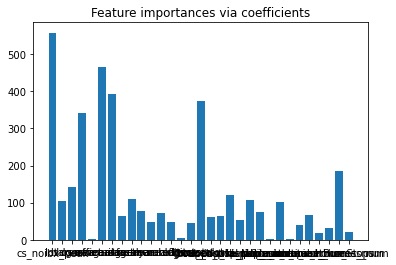

In [ ]:
importance = np.abs(model.coef_)
feature_names = np.array(cols_peak)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [ ]:
tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    model, n_features_to_select=10, direction="backward"
).fit(mg_noIBX_abs_scaled, mg_noIBX_abs['entries_weekday_evening'])
toc_bwd = time()

print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features selected by backward sequential selection: ['cs_noibx_peak' 'lotarea' 'officearea' 'retailarea' 'garagearea'
 'numbldgs' 'assesstot' 'black_num' 'multirace_num' 'vacant_homes_num']
Done in 258.444s


In [ ]:
selected_scale = ['cs_noibx_peak','lotarea','bldgarea','comarea','officearea','retailarea',
 'garagearea', 'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
 'unitstotal', 'assesstot', 'Total_pop_Num', 'housed_pop_Num',
 'group_house_pop_num', 'industrial_pop_num', 'under18_num', 'hispanic_num',
 'black_num', 'multirace_num', 'vacant_homes_num']

In [ ]:
#RidgeCV scores on scaled abs values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Ridge_model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_abs_scaled[selected_scale], mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Ridge_model.score(mg_noIBX_abs_scaled[selected_scale], mg_noIBX_abs[commute_period]))
           importance = np.abs(Ridge_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       elif 'overnight' in commute_period:
           Ridge_model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_abs_scaled[selected_scale], mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Ridge_model.score(mg_noIBX_abs_scaled[selected_scale], mg_noIBX_abs[commute_period]))
           importance = np.abs(Ridge_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       else:
           Ridge_model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_abs_scaled[selected_scale], mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Ridge_model.score(mg_noIBX_abs_scaled[selected_scale], mg_noIBX_abs[commute_period]))
           importance = np.abs(Ridge_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_peak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))

exits_weekday_evening: 0.3438445694267652
exits_weekday_evening Selected Features: ['cs_noibx_peak' 'officearea' 'resarea' 'comarea' 'unitsres']
entries_weekday_evening: 0.5166703894611353
entries_weekday_evening Selected Features: ['cs_noibx_peak' 'resarea' 'officearea' 'unitsres' 'comarea']
exits_weekday_morning: 0.5308025334984426
exits_weekday_morning Selected Features: ['resarea' 'cs_noibx_peak' 'officearea' 'unitsres' 'comarea']
entries_weekday_morning: 0.32704295005247686
entries_weekday_morning Selected Features: ['officearea' 'resarea' 'cs_noibx_peak' 'comarea' 'industrial_pop_num']
exits_weekday_overnight: 0.3085922937069244
exits_weekday_overnight Selected Features: ['cs_noibx_offpeak' 'officearea' 'resarea' 'industrial_pop_num' 'comarea']
entries_weekday_overnight: 0.29573810954696067
entries_weekday_overnight Selected Features: ['cs_noibx_offpeak' 'resarea' 'officearea' 'unitsres' 'comarea']
exits_weekend_evening: 0.3679465282174996
exits_weekend_evening Selected Features: